# Machine Learning-Based Transcriptomic Biomarker Discovery in Huntington's Disease

**Project:** Discovery of Key Biomarkers for Huntington's Disease Using Meta-Analysis and Machine Learning
**Data Source:** GSE64810 (Pre-processed & Filtered)
**Models:** Random Forest (Feature Selection) & Support Vector Machine (Classification)

---

## 1. Setup and Data Loading
Import necessary libraries and upload the `HD_ML_Ready_Data.csv` file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Setup plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
from google.colab import files

print("Please upload 'HD_ML_Ready_Data.csv'")
uploaded = files.upload()

# Check if file is uploaded
filename = list(uploaded.keys())[0]
print(f"Loaded file: {filename}")

data = pd.read_csv(filename)
data.head()

Please upload 'HD_ML_Ready_Data.csv'


Saving HD_ML_Ready_Data.csv to HD_ML_Ready_Data.csv
Loaded file: HD_ML_Ready_Data.csv


,Target_Class,ENSG00000069011.10,ENSG00000163817.11,ENSG00000127083.7,ENSG00000126778.6,ENSG00000166426.7,ENSG00000152779.12,ENSG00000168779.14,ENSG00000096696.9,ENSG00000112303.9,...,ENSG00000042062.7,ENSG00000142973.8,ENSG00000239776.2,ENSG00000196954.8,ENSG00000243449.2,ENSG00000132768.9,ENSG00000203952.5,ENSG00000176845.8,ENSG00000155962.8,ENSG00000115825.5
0,Control,4.071619,6.090280,7.125532,5.382620,7.497715,4.765446,4.765446,6.960278,4.564569,...,8.014083,6.217827,9.888953,7.039835,9.655270,9.433222,6.457747,8.392623,7.597847,9.247964
1,Control,4.071619,5.100674,6.406492,4.765582,7.245451,5.100674,4.765582,7.125984,5.100674,...,7.904945,4.765582,10.152200,7.029189,10.066732,9.761821,6.441144,8.476017,6.995374,9.062880
2,Control,4.421080,6.238176,6.732217,4.765543,7.521798,4.564638,4.673999,6.406381,5.043955,...,7.310590,5.341035,9.219828,6.825564,8.811823,9.315037,6.458025,8.318584,7.424341,9.097114
3,Control,4.071619,6.217818,5.297319,4.564567,7.083328,5.340859,4.421029,6.983465,5.204021,...,7.083328,4.673912,9.573128,7.656120,9.163127,9.010536,6.257690,8.422161,7.698319,8.945244
4,Control,4.071619,6.176926,6.523903,4.564632,7.040122,4.673991,4.845623,6.772973,5.297474,...,7.216359,4.845623,11.759343,6.406355,9.283193,9.370111,6.176926,8.030977,7.166784,8.977201


## 2. Data Preprocessing
Encoding the target variable and splitting the data into training and testing sets.

In [ ]:
# Separate Features (Genes) and Target
X = data.drop('Target_Class', axis=1)
y = data['Target_Class']

# Encode Target (Control -> 0, HD -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Class Mapping: {dict(zip(class_names, le.transform(class_names)))}")

# Split Data (70% Train, 30% Test) - Stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Scale data for SVM (SVM requires feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Number of Features (Genes): {X_train.shape[1]}")

Class Mapping: {'Control': np.int64(0), 'HD': np.int64(1)}
Training samples: 48
Testing samples: 21
Number of Features (Genes): 200


## 3. Model Training
Training Random Forest (for feature importance) and SVM (for high accuracy).

In [ ]:
# --- Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- SVM (Linear Kernel) ---
# probability=True is needed for ROC-AUC
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("Models trained successfully.")

Models trained successfully.


## 4. Evaluation and Visualization
Generating predictions, confusion matrices, and ROC curves.

In [ ]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# --- Metrics Function ---
def print_metrics(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    return confusion_matrix(y_true, y_pred)

cm_rf = print_metrics("Random Forest", y_test, y_pred_rf, y_prob_rf)
cm_svm = print_metrics("SVM", y_test, y_pred_svm, y_prob_svm)


--- Random Forest Results ---
Accuracy: 0.8571
ROC-AUC: 0.9722
Classification Report:
              precision    recall  f1-score   support

     Control       0.88      0.93      0.90        15
          HD       0.80      0.67      0.73         6

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21


--- SVM Results ---
Accuracy: 0.9524
ROC-AUC: 0.9889
Classification Report:
              precision    recall  f1-score   support

     Control       0.94      1.00      0.97        15
          HD       1.00      0.83      0.91         6

    accuracy                           0.95        21
   macro avg       0.97      0.92      0.94        21
weighted avg       0.96      0.95      0.95        21



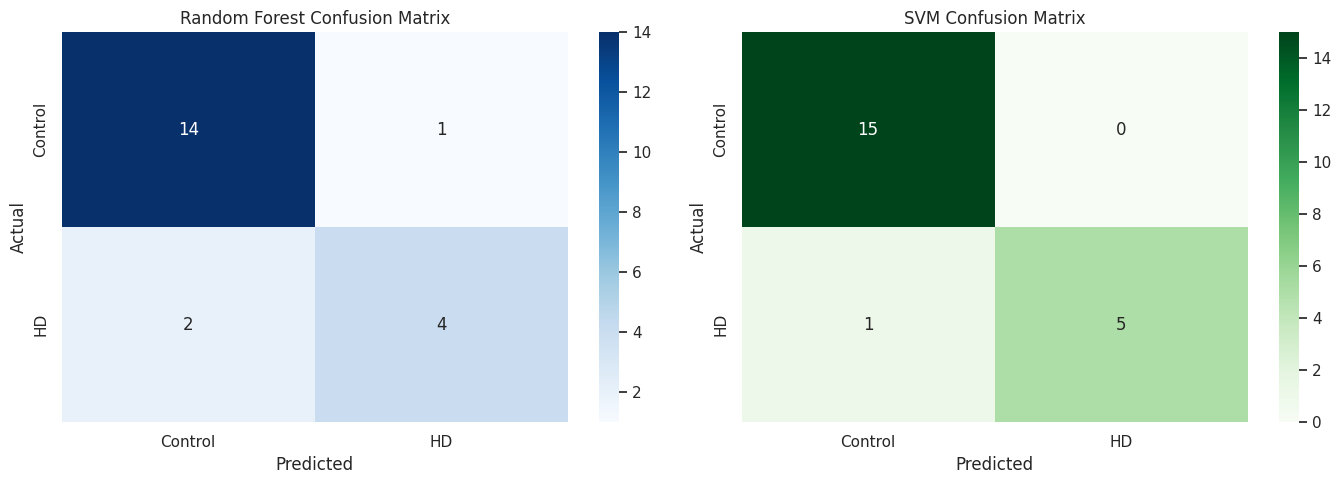

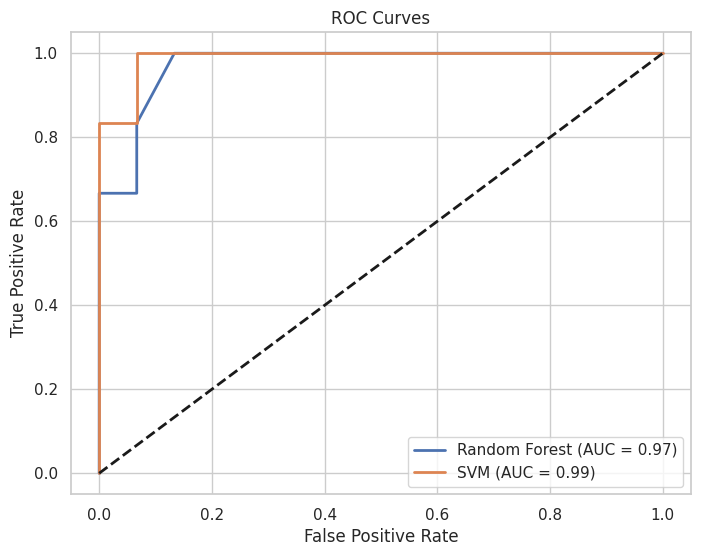

In [ ]:
# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# --- Plot ROC Curves ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})', lw=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test, y_prob_svm):.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

## 5. Feature Importance (Biomarker Identification)
Visualizing the top 20 genes that the Random Forest model used to make decisions.

/tmp/ipython-input-1125345374.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_genes, palette='viridis')


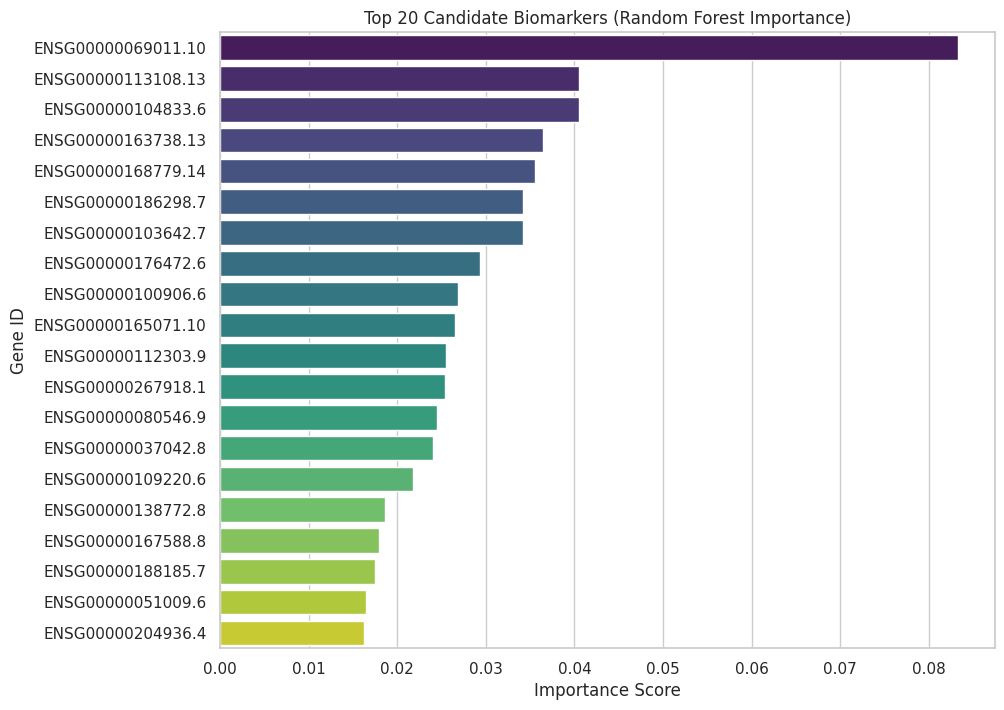

Top 10 Genes:
ENSG00000069011.10: 0.0833
ENSG00000113108.13: 0.0405
ENSG00000104833.6: 0.0405
ENSG00000163738.13: 0.0364
ENSG00000168779.14: 0.0355
ENSG00000186298.7: 0.0342
ENSG00000103642.7: 0.0342
ENSG00000176472.6: 0.0293
ENSG00000100906.6: 0.0268
ENSG00000165071.10: 0.0265


In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20] # Top 20 features

top_genes = X.columns[indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_genes, palette='viridis')
plt.title('Top 20 Candidate Biomarkers (Random Forest Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Gene ID')
plt.show()

print("Top 10 Genes:")
for gene, score in zip(top_genes[:10], top_importances[:10]):
    print(f"{gene}: {score:.4f}")

## 6. Save and Download Models
We will save the trained models, the scaler (crucial for SVM), and the list of feature names (crucial for ensuring input consistency). We'll zip them together for a single download.

In [ ]:
# Create a directory for artifacts
!mkdir -p hd_models

# 1. Save Random Forest Model
joblib.dump(rf_model, 'hd_models/rf_model.pkl')

# 2. Save SVM Model
joblib.dump(svm_model, 'hd_models/svm_model.pkl')

# 3. Save Scaler (Required for SVM inference)
joblib.dump(scaler, 'hd_models/scaler.pkl')

# 4. Save Feature Names (To ensure future input order matches training)
feature_names = list(X.columns)
joblib.dump(feature_names, 'hd_models/feature_names.pkl')

# 5. Save Label Encoder (To decode 0/1 back to Control/HD)
joblib.dump(le, 'hd_models/label_encoder.pkl')

print("Artifacts saved locally in 'hd_models/' folder.")

# Zip the folder
!zip -r hd_models.zip hd_models

# Download the zip file
files.download('hd_models.zip')

Artifacts saved locally in 'hd_models/' folder.
updating: hd_models/ (stored 0%)
updating: hd_models/scaler.pkl (deflated 33%)
updating: hd_models/label_encoder.pkl (deflated 34%)
updating: hd_models/feature_names.pkl (deflated 75%)
updating: hd_models/svm_model.pkl (deflated 19%)
updating: hd_models/rf_model.pkl (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>